**Chapter 16 – Natural Language Processing with RNNs and Attention**

_This notebook contains all the sample code and solutions to the exercises in chapter 16._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml3/blob/main/16_nlp_with_rnns_and_attention.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

**Warning**: the latest TensorFlow versions are based on Keras 3. For previous chapters, it wasn't too hard to update the code to support Keras 3, but unfortunately it's much harder for this chapter: for example, stateful RNNs work very differently, ragged tensors are no longer supported, TensorFlow Hub models are no longer supported, and more. So for this chapter I've had to revert to Keras 2. To do that, I set the `TF_USE_LEGACY_KERAS` environment variable to `"1"` and import the `tf_keras` package. This ensures that `tf.keras` points to `tf_keras`, which is Keras 2.*.

In [2]:
IS_COLAB = "google.colab" in sys.modules
if IS_COLAB:
    import os
    os.environ["TF_USE_LEGACY_KERAS"] = "1"
    import tf_keras

And TensorFlow ≥ 2.8:

In [3]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

As we did in earlier chapters, let's define the default font sizes to make the figures prettier:

In [4]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/nlp` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res for the book:

In [5]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "nlp"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

This chapter can be very slow without a GPU, so let's make sure there's one, or else issue a warning:

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

No GPU was detected. Neural nets can be very slow without a GPU.


# Generating Shakespearean Text Using a Character RNN

## Creating the Training Dataset

Let's download the Shakespeare data from Andrej Karpathy's [char-rnn project](https://github.com/karpathy/char-rnn/)

In [7]:
import tensorflow as tf

shakespeare_url = "https://homl.info/shakespeare"  # shortcut URL
filepath = tf.keras.utils.get_file("shakespeare.txt", shakespeare_url)
with open(filepath) as f:
    shakespeare_text = f.read()

1115394/1115394 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# extra code – shows a short text sample
print(shakespeare_text[:80])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.


In [9]:
# extra code – shows all 39 distinct characters (after converting to lower case)
"".join(sorted(set(shakespeare_text.lower())))

"\n !$&',-.3:;?abcdefghijklmnopqrstuvwxyz"

In [10]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character",
                                                   standardize="lower")
text_vec_layer.adapt([shakespeare_text])
encoded = text_vec_layer([shakespeare_text])[0]

In [11]:
encoded -= 2  # drop tokens 0 (pad) and 1 (unknown), which we will not use
n_tokens = text_vec_layer.vocabulary_size() - 2  # number of distinct chars = 39
dataset_size = len(encoded)  # total number of chars = 1,115,394

In [12]:
n_tokens

39

In [13]:
dataset_size

1115394

In [14]:
def to_dataset(sequence, length, shuffle=False, seed=None, batch_size=32):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window_ds: window_ds.batch(length + 1))
    if shuffle:
        ds = ds.shuffle(100_000, seed=seed)
    ds = ds.batch(batch_size)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

In [15]:
# extra code – a simple example using to_dataset()
# There's just one sample in this dataset: the input represents "to b" and the
# output represents "o be"
list(to_dataset(text_vec_layer(["To be"])[0], length=4))

2025-02-09 15:24:14.780201: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 4,  5,  2, 23]])>,
  <tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[ 5,  2, 23,  3]])>)]

In [16]:
length = 100
tf.random.set_seed(42)
train_set = to_dataset(encoded[:1_000_000], length=length, shuffle=True,
                       seed=42)
valid_set = to_dataset(encoded[1_000_000:1_060_000], length=length)
test_set = to_dataset(encoded[1_060_000:], length=length)

## Building and Training the Char-RNN Model

**Warning**: the following code may one or two hours to run, depending on your GPU. Without a GPU, it may take over 24 hours. If you don't want to wait, just skip the next two code cells and run the code below to download a pretrained model.

**Note**: the `GRU` class will only use cuDNN acceleration (assuming you have a GPU) when using the default values for the following arguments: `activation`, `recurrent_activation`, `recurrent_dropout`, `unroll`, `use_bias` and `reset_after`.

In [17]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_shakespeare_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=10,
                    callbacks=[model_ckpt])

Epoch 1/10


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 1407s 45ms/step - loss: 1.3873 - accuracy: 0.5754 - val_loss: 1.6155 - val_accuracy: 0.5333
Epoch 2/10


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 1376s 44ms/step - loss: 1.2921 - accuracy: 0.5973 - val_loss: 1.5881 - val_accuracy: 0.5401
Epoch 3/10


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 1379s 44ms/step - loss: 1.2743 - accuracy: 0.6015 - val_loss: 1.5885 - val_accuracy: 0.5407
Epoch 4/10


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 1381s 44ms/step - loss: 1.2654 - accuracy: 0.6031 - val_loss: 1.5701 - val_accuracy: 0.5418
Epoch 5/10


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 1379s 44ms/step - loss: 1.2594 - accuracy: 0.6045 - val_loss: 1.5674 - val_accuracy: 0.5450
Epoch 6/10


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 1386s 44ms/step - loss: 1.2545 - accuracy: 0.6058 - val_loss: 1.5587 - val_accuracy: 0.5492
Epoch 7/10
31247/31247 [==============================] - 1381s 44ms/step - loss: 1.2514 - accuracy: 0.6062 - val_loss: 1.5532 - val_accuracy: 0.5460
Epoch 8/10
31247/31247 [==============================] - 1381s 44ms/step - loss: 1.2485 - accuracy: 0.6067 - val_loss: 1.5522 - val_accuracy: 0.5479
Epoch 9/10


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 1382s 44ms/step - loss: 1.2460 - accuracy: 0.6073 - val_loss: 1.5521 - val_accuracy: 0.5497
Epoch 10/10


INFO:tensorflow:Assets written to: my_shakespeare_model/assets


31247/31247 [==============================] - 1385s 44ms/step - loss: 1.2436 - accuracy: 0.6080 - val_loss: 1.5477 - val_accuracy: 0.5513


In [18]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    model
])

If you don't want to wait for training to complete, I've pretrained a model for you. The following code will download it. Uncomment the last line if you want to use it instead of the model trained above.

In [19]:
# extra code – downloads a pretrained model
url = "https://github.com/ageron/data/raw/main/shakespeare_model.tgz"
path = tf.keras.utils.get_file("shakespeare_model.tgz", url, extract=True)
if "_extracted" in path:
    model_path = Path(path) / "shakespeare_model"
else:
    model_path = Path(path).with_name("shakespeare_model")
#shakespeare_model = tf.keras.models.load_model(model_path)

352865/352865 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [20]:
y_proba = shakespeare_model.predict(["To be or not to b"])[0, -1]
y_pred = tf.argmax(y_proba)  # choose the most probable character ID
text_vec_layer.get_vocabulary()[y_pred + 2]

'e'

## Generating Fake Shakespearean Text

In [21]:
log_probas = tf.math.log([[0.5, 0.4, 0.1]])  # probas = 50%, 40%, and 10%
tf.random.set_seed(42)
tf.random.categorical(log_probas, num_samples=8)  # draw 8 samples

<tf.Tensor: shape=(1, 8), dtype=int64, numpy=array([[0, 1, 0, 2, 1, 0, 0, 1]])>

In [22]:
def next_char(text, temperature=1):
    y_proba = shakespeare_model.predict([text])[0, -1:]
    rescaled_logits = tf.math.log(y_proba) / temperature
    char_id = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0]
    return text_vec_layer.get_vocabulary()[char_id + 2]

In [23]:
def extend_text(text, n_chars=50, temperature=1):
    for _ in range(n_chars):
        text += next_char(text, temperature)
    return text

In [24]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU

In [25]:
print(extend_text("To be or not to be", temperature=0.01))

To be or not to be the duke
as it is a proper strange death,
and the


In [26]:
print(extend_text("To be or not to be", temperature=1))

To be or not to behold?

second push:
gremio, lord all, a sistermen,


In [27]:
print(extend_text("To be or not to be", temperature=100))

To be or not to bef ,mt'&o3fpadm!$
wh!nse?bws3est--vgerdjw?c-y-ewznq


## Stateful RNN

In [28]:
def to_dataset_for_stateful_rnn(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(length + 1)).batch(1)
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

stateful_train_set = to_dataset_for_stateful_rnn(encoded[:1_000_000], length)
stateful_valid_set = to_dataset_for_stateful_rnn(encoded[1_000_000:1_060_000],
                                                 length)
stateful_test_set = to_dataset_for_stateful_rnn(encoded[1_060_000:], length)

In [29]:
# extra code – simple example using to_dataset_for_stateful_rnn()
list(to_dataset_for_stateful_rnn(tf.range(10), 3))

[(<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[0, 1, 2]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[1, 2, 3]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[3, 4, 5]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[4, 5, 6]], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[6, 7, 8]], dtype=int32)>,
  <tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[7, 8, 9]], dtype=int32)>)]

If you'd like to have more than one window per batch, you can use the `to_batched_dataset_for_stateful_rnn()` function instead of `to_dataset_for_stateful_rnn()`:

In [30]:
# extra code – shows one way to prepare a batched dataset for a stateful RNN

import numpy as np

def to_non_overlapping_windows(sequence, length):
    ds = tf.data.Dataset.from_tensor_slices(sequence)
    ds = ds.window(length + 1, shift=length, drop_remainder=True)
    return ds.flat_map(lambda window: window.batch(length + 1))

def to_batched_dataset_for_stateful_rnn(sequence, length, batch_size=32):
    parts = np.array_split(sequence, batch_size)
    datasets = tuple(to_non_overlapping_windows(part, length) for part in parts)
    ds = tf.data.Dataset.zip(datasets).map(lambda *windows: tf.stack(windows))
    return ds.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

list(to_batched_dataset_for_stateful_rnn(tf.range(20), length=3, batch_size=2))

[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 0,  1,  2],
         [10, 11, 12]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 1,  2,  3],
         [11, 12, 13]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 3,  4,  5],
         [13, 14, 15]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 4,  5,  6],
         [14, 15, 16]], dtype=int32)>),
 (<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 6,  7,  8],
         [16, 17, 18]], dtype=int32)>,
  <tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[ 7,  8,  9],
         [17, 18, 19]], dtype=int32)>)]

In [31]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16,
                              batch_input_shape=[1, None]),
    tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

In [32]:
class ResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()

In [33]:
# extra code – use a different directory to save the checkpoints
model_ckpt = tf.keras.callbacks.ModelCheckpoint(
    "my_stateful_shakespeare_model",
    monitor="val_accuracy",
    save_best_only=True)

**Warning**: the following cell will take a while to run (possibly an hour if you are not using a GPU).

In [34]:
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(stateful_train_set, validation_data=stateful_valid_set,
                    epochs=10, callbacks=[ResetStatesCallback(), model_ckpt])

INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 213s 21ms/step - loss: 1.8690 - accuracy: 0.4494 - val_loss: 1.7632 - val_accuracy: 0.4672
Epoch 2/10


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 211s 21ms/step - loss: 1.5635 - accuracy: 0.5284 - val_loss: 1.6334 - val_accuracy: 0.4994
Epoch 3/10


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 209s 21ms/step - loss: 1.4875 - accuracy: 0.5478 - val_loss: 1.5788 - val_accuracy: 0.5153
Epoch 4/10


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 208s 21ms/step - loss: 1.4483 - accuracy: 0.5579 - val_loss: 1.5471 - val_accuracy: 0.5236
Epoch 5/10


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 213s 21ms/step - loss: 1.4241 - accuracy: 0.5643 - val_loss: 1.5270 - val_accuracy: 0.5286
Epoch 6/10


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 215s 21ms/step - loss: 1.4074 - accuracy: 0.5686 - val_loss: 1.5109 - val_accuracy: 0.5338
Epoch 7/10


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 210s 21ms/step - loss: 1.3953 - accuracy: 0.5714 - val_loss: 1.5008 - val_accuracy: 0.5361
Epoch 8/10


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 212s 21ms/step - loss: 1.3863 - accuracy: 0.5737 - val_loss: 1.4938 - val_accuracy: 0.5381
Epoch 9/10
9999/9999 [==============================] - 207s 21ms/step - loss: 1.3790 - accuracy: 0.5757 - val_loss: 1.4890 - val_accuracy: 0.5380
Epoch 10/10


INFO:tensorflow:Assets written to: my_stateful_shakespeare_model/assets


9999/9999 [==============================] - 208s 21ms/step - loss: 1.3729 - accuracy: 0.5770 - val_loss: 1.4786 - val_accuracy: 0.5420


**Extra Material: converting the stateful RNN to a stateless RNN and using it**

To use the model with different batch sizes, we need to create a stateless copy:

In [35]:
stateless_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=n_tokens, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(n_tokens, activation="softmax")
])

To set the weights, we first need to build the model (so the weights get created):

In [36]:
stateless_model.build(tf.TensorShape([None, None]))

In [37]:
stateless_model.set_weights(model.get_weights())

In [38]:
shakespeare_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2),  # no <PAD> or <UNK> tokens
    stateless_model
])

In [39]:
tf.random.set_seed(42)

print(extend_text("to be or not to be", temperature=0.01))

to be or not to be so in the world and the strangeness
to see the wo


# Sentiment Analysis

In [40]:
import tensorflow_datasets as tfds

raw_train_set, raw_valid_set, raw_test_set = tfds.load(
    name="imdb_reviews",
    split=["train[:90%]", "train[90%:]", "test"],
    as_supervised=True
)
tf.random.set_seed(42)
train_set = raw_train_set.shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = raw_valid_set.batch(32).prefetch(1)
test_set = raw_test_set.batch(32).prefetch(1)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /home/ageron/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0WPKUH/imdb_reviews-train.t…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /home/ageron/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0WPKUH/imdb_reviews-test.tf…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /home/ageron/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete0WPKUH/imdb_reviews-unsuper…

Dataset imdb_reviews downloaded and prepared to /home/ageron/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [41]:
for review, label in raw_train_set.take(4):
    print(review.numpy().decode("utf-8")[:200], "...")
    print("Label:", label.numpy())

This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting  ...
Label: 0
I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However  ...
Label: 0
Mann photographs the Alberta Rocky Mountains in a superb fashion, and Jimmy Stewart and Walter Brennan give enjoyable performances as they always seem to do. <br /><br />But come on Hollywood - a Moun ...
Label: 0
This is the kind of film for a snowy Sunday afternoon when the rest of the world can go ahead with its own business as you descend into a big arm-chair and mellow for a couple of hours. Wonderful perf ...
Label: 1


In [42]:
vocab_size = 1000
text_vec_layer = tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec_layer.adapt(train_set.map(lambda reviews, labels: reviews))

**Warning**: the following cell will take a few minutes to run and the model will probably not learn anything because we didn't mask the padding tokens (that's the point of the next section).

In [43]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=2)

Epoch 1/2
704/704 [==============================] - 255s 359ms/step - loss: 0.6934 - accuracy: 0.4990 - val_loss: 0.6931 - val_accuracy: 0.5016
Epoch 2/2
704/704 [==============================] - 250s 355ms/step - loss: 0.6934 - accuracy: 0.5042 - val_loss: 0.6942 - val_accuracy: 0.5008


## Masking

**Warning**: the following cell will take a while to run (possibly 30 minutes if you are not using a GPU).

In [44]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Embedding(vocab_size, embed_size, mask_zero=True),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 303s 426ms/step - loss: 0.5296 - accuracy: 0.7234 - val_loss: 0.4045 - val_accuracy: 0.8244
Epoch 2/5
704/704 [==============================] - 295s 419ms/step - loss: 0.3702 - accuracy: 0.8418 - val_loss: 0.3390 - val_accuracy: 0.8532
Epoch 3/5
704/704 [==============================] - 298s 423ms/step - loss: 0.3057 - accuracy: 0.8747 - val_loss: 0.3196 - val_accuracy: 0.8696
Epoch 4/5
704/704 [==============================] - 294s 418ms/step - loss: 0.2784 - accuracy: 0.8871 - val_loss: 0.3162 - val_accuracy: 0.8596
Epoch 5/5
704/704 [==============================] - 293s 417ms/step - loss: 0.2597 - accuracy: 0.8961 - val_loss: 0.3209 - val_accuracy: 0.8548


Or using manual masking:

In [45]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on the CPU
inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
token_ids = text_vec_layer(inputs)
mask = tf.math.not_equal(token_ids, 0)
Z = tf.keras.layers.Embedding(vocab_size, embed_size)(token_ids)
Z = tf.keras.layers.GRU(128, dropout=0.2)(Z, mask=mask)
outputs = tf.keras.layers.Dense(1, activation="sigmoid")(Z)
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])

**Warning**: the following cell will take a while to run (possibly 30 minutes if you are not using a GPU).

In [46]:
# extra code – compiles and trains the model, as usual
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 303s 427ms/step - loss: 0.5447 - accuracy: 0.7198 - val_loss: 0.4604 - val_accuracy: 0.7720
Epoch 2/5
704/704 [==============================] - 301s 427ms/step - loss: 0.3469 - accuracy: 0.8512 - val_loss: 0.3214 - val_accuracy: 0.8608
Epoch 3/5
704/704 [==============================] - 295s 419ms/step - loss: 0.3054 - accuracy: 0.8713 - val_loss: 0.3069 - val_accuracy: 0.8672
Epoch 4/5
704/704 [==============================] - 295s 420ms/step - loss: 0.2798 - accuracy: 0.8828 - val_loss: 0.3028 - val_accuracy: 0.8672
Epoch 5/5
704/704 [==============================] - 298s 423ms/step - loss: 0.2622 - accuracy: 0.8920 - val_loss: 0.2953 - val_accuracy: 0.8700


**Extra material: using ragged tensors**

In [47]:
text_vec_layer_ragged = tf.keras.layers.TextVectorization(
    max_tokens=vocab_size, ragged=True)
text_vec_layer_ragged.adapt(train_set.map(lambda reviews, labels: reviews))
text_vec_layer_ragged(["Great movie!", "This is DiCaprio's best role."])

<tf.RaggedTensor [[86, 18], [11, 7, 1, 116, 217]]>

In [48]:
text_vec_layer(["Great movie!", "This is DiCaprio's best role."])

<tf.Tensor: shape=(2, 5), dtype=int64, numpy=
array([[ 86,  18,   0,   0,   0],
       [ 11,   7,   1, 116, 217]])>

**Warning**: the following cell will take a while to run (possibly 30 minutes if you are not using a GPU).

In [49]:
embed_size = 128
tf.random.set_seed(42)
model = tf.keras.Sequential([
    text_vec_layer_ragged,
    tf.keras.layers.Embedding(vocab_size, embed_size),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=5)

Epoch 1/5
704/704 [==============================] - 280s 395ms/step - loss: 0.5038 - accuracy: 0.7496 - val_loss: 0.6706 - val_accuracy: 0.6752
Epoch 2/5
704/704 [==============================] - 277s 393ms/step - loss: 0.4499 - accuracy: 0.7892 - val_loss: 0.3494 - val_accuracy: 0.8500
Epoch 3/5
704/704 [==============================] - 276s 392ms/step - loss: 0.3270 - accuracy: 0.8592 - val_loss: 0.3855 - val_accuracy: 0.8260
Epoch 4/5
704/704 [==============================] - 277s 394ms/step - loss: 0.2935 - accuracy: 0.8760 - val_loss: 0.3401 - val_accuracy: 0.8520
Epoch 5/5
704/704 [==============================] - 275s 390ms/step - loss: 0.2742 - accuracy: 0.8854 - val_loss: 0.3971 - val_accuracy: 0.8208


## Reusing Pretrained Embeddings and Language Models

**Warning**: the following cell will take a while to run (possibly an hour if you are not using a GPU).

In [50]:
import os
import tensorflow_hub as hub

os.environ["TFHUB_CACHE_DIR"] = "my_tfhub_cache"
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
model = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                   trainable=True, dtype=tf.string, input_shape=[]),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
704/704 [==============================] - 224s 303ms/step - loss: 0.3141 - accuracy: 0.8648 - val_loss: 0.2397 - val_accuracy: 0.9008
Epoch 2/10
704/704 [==============================] - 205s 291ms/step - loss: 0.0489 - accuracy: 0.9852 - val_loss: 0.3257 - val_accuracy: 0.8936
Epoch 3/10
704/704 [==============================] - 204s 290ms/step - loss: 0.0061 - accuracy: 0.9988 - val_loss: 0.3963 - val_accuracy: 0.8944
Epoch 4/10
704/704 [==============================] - 204s 290ms/step - loss: 9.4918e-04 - accuracy: 0.9999 - val_loss: 0.4291 - val_accuracy: 0.8924
Epoch 5/10
704/704 [==============================] - 203s 289ms/step - loss: 5.1920e-04 - accuracy: 1.0000 - val_loss: 0.4691 - val_accuracy: 0.8932
Epoch 6/10
704/704 [==============================] - 204s 289ms/step - loss: 5.0053e-04 - accuracy: 1.0000 - val_loss: 0.4687 - val_accuracy: 0.8912
Epoch 7/10
704/704 [==============================] - 208s 296ms/step - loss: 3.7360e-04 - accuracy: 1.0000 - va

# An Encoder–Decoder Network for Neural Machine Translation

In [51]:
url = "https://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
path = tf.keras.utils.get_file("spa-eng.zip", origin=url, cache_dir="datasets",
                               extract=True)
text = (Path(path).with_name("spa-eng") / "spa.txt").read_text()

In [52]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  # extra code – ensures reproducibility on CPU
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  # separates the pairs into 2 lists

In [53]:
for i in range(3):
    print(sentences_en[i], "=>", sentences_es[i])

How boring! => Qué aburrimiento!
I love sports. => Adoro el deporte.
Would you like to swap jobs? => Te gustaría que intercambiemos los trabajos?


In [54]:
vocab_size = 1000
max_length = 50
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [55]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'i', 'to', 'you', 'tom', 'a', 'is', 'he']

In [56]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'de', 'que', 'a', 'no', 'tom', 'la']

In [57]:
X_train = tf.constant(sentences_en[:100_000])
X_valid = tf.constant(sentences_en[100_000:])
X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:100_000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[100_000:]])
Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:100_000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[100_000:]])

In [58]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [59]:
embed_size = 128
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_es(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [60]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [61]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [62]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

**Warning**: the following cell will take a while to run (possibly a couple hours if you are not using a GPU).

In [63]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 698s 221ms/step - loss: 0.4154 - accuracy: 0.4256 - val_loss: 0.3069 - val_accuracy: 0.5246
Epoch 2/10
3125/3125 [==============================] - 686s 219ms/step - loss: 0.2631 - accuracy: 0.5745 - val_loss: 0.2367 - val_accuracy: 0.6055
Epoch 3/10
3125/3125 [==============================] - 686s 220ms/step - loss: 0.2066 - accuracy: 0.6457 - val_loss: 0.2061 - val_accuracy: 0.6500
Epoch 4/10
3125/3125 [==============================] - 682s 218ms/step - loss: 0.1740 - accuracy: 0.6907 - val_loss: 0.1920 - val_accuracy: 0.6691
Epoch 5/10
3125/3125 [==============================] - 676s 216ms/step - loss: 0.1507 - accuracy: 0.7237 - val_loss: 0.1865 - val_accuracy: 0.6767
Epoch 6/10
3125/3125 [==============================] - 675s 216ms/step - loss: 0.1316 - accuracy: 0.7522 - val_loss: 0.1847 - val_accuracy: 0.6804
Epoch 7/10
3125/3125 [==============================] - 675s 216ms/step - loss: 0.1154 - accuracy: 0.7774 - val_

In [64]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [65]:
translate("I like soccer")

'me gusta el fútbol'

Nice! However, the model struggles with longer sentences:

In [66]:
translate("I like soccer and also going to the beach")

'me gusta el fútbol y a veces mismo al bus'

## Bidirectional RNNs

To create a bidirectional recurrent layer, just wrap a regular recurrent layer in a `Bidirectional` layer:

In [67]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [68]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

**Warning**: the following cell will take a while to run (possibly a couple hours if you are not using a GPU).

In [69]:
# extra code — completes the model and trains it
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 574s 181ms/step - loss: 0.3075 - accuracy: 0.5393 - val_loss: 0.2192 - val_accuracy: 0.6319
Epoch 2/10
3125/3125 [==============================] - 564s 180ms/step - loss: 0.1916 - accuracy: 0.6689 - val_loss: 0.1880 - val_accuracy: 0.6731
Epoch 3/10
3125/3125 [==============================] - 566s 181ms/step - loss: 0.1602 - accuracy: 0.7119 - val_loss: 0.1751 - val_accuracy: 0.6916
Epoch 4/10
3125/3125 [==============================] - 566s 181ms/step - loss: 0.1395 - accuracy: 0.7415 - val_loss: 0.1715 - val_accuracy: 0.6979
Epoch 5/10
3125/3125 [==============================] - 566s 181ms/step - loss: 0.1227 - accuracy: 0.7666 - val_loss: 0.1707 - val_accuracy: 0.7025
Epoch 6/10
3125/3125 [==============================] - 567s 181ms/step - loss: 0.1085 - accuracy: 0.7887 - val_loss: 0.1730 - val_accuracy: 0.6995
Epoch 7/10
3125/3125 [==============================] - 571s 183ms/step - loss: 0.0961 - accuracy: 0.8089 - val_

In [70]:
translate("I like soccer")

'me gusta el fútbol'

## Beam Search

This is a very basic implementation of beam search. I tried to make it readable and understandable, but it's definitely not optimized for speed! The function first uses the model to find the top _k_ words to start the translations (where _k_ is the beam width). For each of the top _k_ translations, it evaluates the conditional probabilities of all possible words it could add to that translation. These extended translations and their probabilities are added to the list of candidates. Once we've gone through all top _k_ translations and all words that could complete them, we keep only the top _k_ candidates with the highest probability, and we iterate over and over until they all finish with an EOS token. The top translation is then returned (after removing its EOS token).

* Note: If p(S) is the probability of sentence S, and p(W|S) is the conditional probability of the word W given that the translation starts with S, then the probability of the sentence S' = concat(S, W) is p(S') = p(S) * p(W|S). As we add more words, the probability gets smaller and smaller. To avoid the risk of it getting too small, which could cause floating point precision errors, the function keeps track of log probabilities instead of probabilities: recall that log(a\*b) = log(a) + log(b), therefore log(p(S')) = log(p(S)) + log(p(W|S)).

In [71]:
# extra code – a basic implementation of beam search

def beam_search(sentence_en, beam_width, verbose=False):
    X = np.array([sentence_en])  # encoder input
    X_dec = np.array(["startofseq"])  # decoder input
    y_proba = model.predict((X, X_dec))[0, 0]  # first token's probas
    top_k = tf.math.top_k(y_proba, k=beam_width)
    top_translations = [  # list of best (log_proba, translation)
        (np.log(word_proba), text_vec_layer_es.get_vocabulary()[word_id])
        for word_proba, word_id in zip(top_k.values, top_k.indices)
    ]
    
    # extra code – displays the top first words in verbose mode
    if verbose:
        print("Top first words:", top_translations)

    for idx in range(1, max_length):
        candidates = []
        for log_proba, translation in top_translations:
            if translation.endswith("endofseq"):
                candidates.append((log_proba, translation))
                continue  # translation is finished, so don't try to extend it
            X = np.array([sentence_en])  # encoder input
            X_dec = np.array(["startofseq " + translation])  # decoder input
            y_proba = model.predict((X, X_dec))[0, idx]  # last token's proba
            for word_id, word_proba in enumerate(y_proba):
                word = text_vec_layer_es.get_vocabulary()[word_id]
                candidates.append((log_proba + np.log(word_proba),
                                   f"{translation} {word}"))
        top_translations = sorted(candidates, reverse=True)[:beam_width]

        # extra code – displays the top translation so far in verbose mode
        if verbose:
            print("Top translations so far:", top_translations)

        if all([tr.endswith("endofseq") for _, tr in top_translations]):
            return top_translations[0][1].replace("endofseq", "").strip()

In [72]:
# extra code – shows how the model making an error
sentence_en = "I love cats and dogs"
translate(sentence_en)

'me [UNK] los gatos y los gatos'

In [73]:
# extra code – shows how beam search can help
beam_search(sentence_en, beam_width=3, verbose=True)

Top first words: [(-0.012974381, 'me'), (-4.592527, '[UNK]'), (-6.314033, 'yo')]
Top translations so far: [(-0.4831518, 'me [UNK]'), (-1.4920667, 'me encanta'), (-1.986235, 'me gustan')]
Top translations so far: [(-0.6793061, 'me [UNK] los'), (-1.9889652, 'me gustan los'), (-2.0470557, 'me encanta los')]
Top translations so far: [(-0.7609749, 'me [UNK] los gatos'), (-2.0677316, 'me gustan los gatos'), (-2.26029, 'me encanta los gatos')]
Top translations so far: [(-0.76985043, 'me [UNK] los gatos y'), (-2.0701222, 'me gustan los gatos y'), (-2.2649746, 'me encanta los gatos y')]
Top translations so far: [(-0.81283045, 'me [UNK] los gatos y los'), (-2.118244, 'me gustan los gatos y los'), (-2.96167, 'me encanta los gatos y los')]
Top translations so far: [(-1.2259341, 'me [UNK] los gatos y los gatos'), (-1.9556838, 'me [UNK] los gatos y los perros'), (-2.7524388, 'me gustan los gatos y los perros')]
Top translations so far: [(-1.2261332, 'me [UNK] los gatos y los gatos endofseq'), (-1.95

'me [UNK] los gatos y los gatos'

The correct translation is in the top 3 sentences found by beam search, but it's not the first. Since we're using a small vocabulary, the \[UNK] token is quite frequent, so you may want to penalize it (e.g., divide its probability by 2 in the beam search function): this will discourage beam search from using it too much.

# Attention Mechanisms

We need to feed all the encoder's outputs to the `Attention` layer, so we must add `return_sequences=True` to the encoder:

In [74]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

In [75]:
# extra code – this part of the model is exactly the same as earlier
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

And finally, let's add the `Attention` layer and the output layer:

In [76]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

**Warning**: the following cell will take a while to run (possibly a couple hours if you are not using a GPU).

In [77]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 597s 189ms/step - loss: 0.3074 - accuracy: 0.5469 - val_loss: 0.2106 - val_accuracy: 0.6487
Epoch 2/10
3125/3125 [==============================] - 585s 187ms/step - loss: 0.1902 - accuracy: 0.6789 - val_loss: 0.1865 - val_accuracy: 0.6830
Epoch 3/10
3125/3125 [==============================] - 585s 187ms/step - loss: 0.1659 - accuracy: 0.7123 - val_loss: 0.1759 - val_accuracy: 0.7005
Epoch 4/10
3125/3125 [==============================] - 584s 187ms/step - loss: 0.1493 - accuracy: 0.7359 - val_loss: 0.1728 - val_accuracy: 0.7060
Epoch 5/10
3125/3125 [==============================] - 582s 186ms/step - loss: 0.1358 - accuracy: 0.7548 - val_loss: 0.1724 - val_accuracy: 0.7084
Epoch 6/10
3125/3125 [==============================] - 583s 186ms/step - loss: 0.1245 - accuracy: 0.7712 - val_loss: 0.1738 - val_accuracy: 0.7103
Epoch 7/10
3125/3125 [==============================] - 582s 186ms/step - loss: 0.1148 - accuracy: 0.7863 - val_

In [78]:
translate("I like soccer and also going to the beach")

'me gusta el fútbol y también ir a la playa'

In [79]:
beam_search("I like soccer and also going to the beach", beam_width=3,
            verbose=True)

Top first words: [(-0.26210824, 'me'), (-2.553061, 'prefiero'), (-3.2005944, 'yo')]
Top translations so far: [(-0.32478744, 'me gusta'), (-3.0608056, 'prefiero el'), (-3.1685317, 'me gustan')]
Top translations so far: [(-0.7464272, 'me gusta el'), (-2.4712462, 'me gusta fútbol'), (-2.9149299, 'me gusta al')]
Top translations so far: [(-1.0369574, 'me gusta el fútbol'), (-2.3301778, 'me gusta el el'), (-2.9658434, 'me gusta fútbol y')]
Top translations so far: [(-1.0404125, 'me gusta el fútbol y'), (-2.5983238, 'me gusta el el fútbol'), (-2.9736564, 'me gusta fútbol y también')]
Top translations so far: [(-1.0520902, 'me gusta el fútbol y también'), (-2.6003318, 'me gusta el el fútbol y'), (-3.128903, 'me gusta fútbol y también me')]
Top translations so far: [(-1.9568634, 'me gusta el fútbol y también ir'), (-2.6169589, 'me gusta el el fútbol y también'), (-2.6949644, 'me gusta el fútbol y también fuera')]
Top translations so far: [(-1.9676423, 'me gusta el fútbol y también ir a'), (-2.

'me gusta el fútbol y también ir a la playa'

## Attention Is All You Need: The Transformer Architecture
### Positional encodings

In [80]:
max_length = 50  # max length in the whole training set
embed_size = 128
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

Alternatively, we can use fixed, non-trainable positional encodings:

In [81]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [82]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

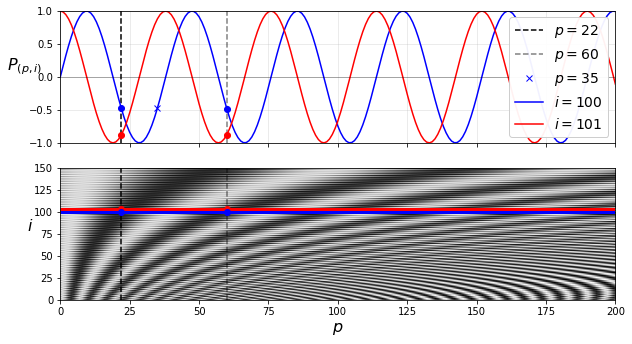

In [83]:
# extra code – this cells generates and saves Figure 16–9
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

### Multi-Head Attention

In [84]:
N = 2  # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # for the first Dense layer in each Feed Forward block
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [85]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(  # creates a lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)

In [86]:
encoder_outputs = Z  # let's save the encoder's final outputs
Z = decoder_in  # the decoder starts with its own inputs
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

**Warning**: the following cell will take a while to run (possibly 2 or 3 hours if you are not using a GPU).

In [87]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
3125/3125 [==============================] - 828s 263ms/step - loss: 0.2982 - accuracy: 0.5545 - val_loss: 0.2105 - val_accuracy: 0.6476
Epoch 2/10
3125/3125 [==============================] - 820s 262ms/step - loss: 0.2006 - accuracy: 0.6601 - val_loss: 0.1876 - val_accuracy: 0.6802
Epoch 3/10
3125/3125 [==============================] - 820s 263ms/step - loss: 0.1842 - accuracy: 0.6816 - val_loss: 0.1766 - val_accuracy: 0.6975
Epoch 4/10
3125/3125 [==============================] - 820s 262ms/step - loss: 0.1748 - accuracy: 0.6942 - val_loss: 0.1704 - val_accuracy: 0.7055
Epoch 5/10
3125/3125 [==============================] - 820s 262ms/step - loss: 0.1683 - accuracy: 0.7021 - val_loss: 0.1657 - val_accuracy: 0.7102
Epoch 6/10
3125/3125 [==============================] - 821s 263ms/step - loss: 0.1628 - accuracy: 0.7096 - val_loss: 0.1628 - val_accuracy: 0.7130
Epoch 7/10
3125/3125 [==============================] - 826s 264ms/step - loss: 0.1588 - accuracy: 0.7154 - val_

In [88]:
translate("I like soccer and also going to the beach")

'me gusta el fútbol y yo también voy a la playa'

# HuggingFace

In [89]:
from transformers import pipeline

classifier = pipeline("sentiment-analysis")  # many other tasks are available
result = classifier("The actors were very convincing.")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
All model checkpoint layers were used when initializing TFDistilBertForSequenceClassification.

All the layers of TFDistilBertForSequenceClassification were initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertForSequenceClassification for predictions without further training.


Models can be very biased. For example, it may like or dislike some countries depending on the data it was trained on, and how it is used, so use it with care:

In [90]:
classifier(["I am from India.", "I am from Iraq."])

[{'label': 'POSITIVE', 'score': 0.9896161556243896},
 {'label': 'NEGATIVE', 'score': 0.9811071157455444}]

In [91]:
model_name = "huggingface/distilbert-base-uncased-finetuned-mnli"
classifier_mnli = pipeline("text-classification", model=model_name)
classifier_mnli("She loves me. [SEP] She loves me not.")

Some layers from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli and are newly initialized: ['dropout_39']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


[{'label': 'contradiction', 'score': 0.9790192246437073}]

In [92]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = TFAutoModelForSequenceClassification.from_pretrained(model_name)

Some layers from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at huggingface/distilbert-base-uncased-finetuned-mnli and are newly initialized: ['dropout_59']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [93]:
token_ids = tokenizer(["I like soccer. [SEP] We all love soccer!",
                       "Joe lived for a very long time. [SEP] Joe is old."],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [94]:
token_ids = tokenizer([("I like soccer.", "We all love soccer!"),
                       ("Joe lived for a very long time.", "Joe is old.")],
                      padding=True, return_tensors="tf")
token_ids

{'input_ids': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[ 101, 1045, 2066, 4715, 1012,  102, 2057, 2035, 2293, 4715,  999,
         102,    0,    0,    0],
       [ 101, 3533, 2973, 2005, 1037, 2200, 2146, 2051, 1012,  102, 3533,
        2003, 2214, 1012,  102]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2, 15), dtype=int32, numpy=
array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
       [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], dtype=int32)>}

In [95]:
outputs = model(token_ids)
outputs

TFSequenceClassifierOutput(loss=None, logits=<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[-2.1123817 ,  1.1786783 ,  1.4101017 ],
       [-0.01478387,  1.0962474 , -0.9919954 ]], dtype=float32)>, hidden_states=None, attentions=None)

In [96]:
Y_probas = tf.keras.activations.softmax(outputs.logits)
Y_probas

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.01619702, 0.43523544, 0.5485676 ],
       [0.22655967, 0.6881726 , 0.0852678 ]], dtype=float32)>

In [97]:
Y_pred = tf.argmax(Y_probas, axis=1)
Y_pred  # 0 = contradiction, 1 = entailment, 2 = neutral

<tf.Tensor: shape=(2,), dtype=int64, numpy=array([2, 1])>

In [98]:
sentences = [("Sky is blue", "Sky is red"), ("I love her", "She loves me")]
X_train = tokenizer(sentences, padding=True, return_tensors="tf").data
y_train = tf.constant([0, 2])  # contradiction, neutral
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(loss=loss, optimizer="nadam", metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=2)

Epoch 1/2
1/1 [==============================] - 10s 10s/step - loss: 1.1190 - accuracy: 0.5000
Epoch 2/2
1/1 [==============================] - 0s 491ms/step - loss: 0.6666 - accuracy: 0.5000


# Exercise solutions

## 1. to 7.

1. Stateless RNNs can only capture patterns whose length is less than, or equal to, the size of the windows the RNN is trained on. Conversely, stateful RNNs can capture longer-term patterns. However, implementing a stateful RNN is much harder⁠—especially preparing the dataset properly. Moreover, stateful RNNs do not always work better, in part because consecutive batches are not independent and identically distributed (IID). Gradient Descent is not fond of non-IID datasets.
2. In general, if you translate a sentence one word at a time, the result will be terrible. For example, the French sentence "Je vous en prie" means "You are welcome," but if you translate it one word at a time, you get "I you in pray." Huh? It is much better to read the whole sentence first and then translate it. A plain sequence-to-sequence RNN would start translating a sentence immediately after reading the first word, while an Encoder–Decoder RNN will first read the whole sentence and then translate it. That said, one could imagine a plain sequence-to-sequence RNN that would output silence whenever it is unsure about what to say next (just like human translators do when they must translate a live broadcast).
3. Variable-length input sequences can be handled by padding the shorter sequences so that all sequences in a batch have the same length, and using masking to ensure the RNN ignores the padding token. For better performance, you may also want to create batches containing sequences of similar sizes. Ragged tensors can hold sequences of variable lengths, and Keras now supports them, which simplifies handling variable-length input sequences (at the time of this writing, it still does not handle ragged tensors as targets on the GPU, though). Regarding variable-length output sequences, if the length of the output sequence is known in advance (e.g., if you know that it is the same as the input sequence), then you just need to configure the loss function so that it ignores tokens that come after the end of the sequence. Similarly, the code that will use the model should ignore tokens beyond the end of the sequence. But generally the length of the output sequence is not known ahead of time, so the solution is to train the model so that it outputs an end-of-sequence token at the end of each sequence.
4. Beam search is a technique used to improve the performance of a trained Encoder–Decoder model, for example in a neural machine translation system. The algorithm keeps track of a short list of the _k_ most promising output sentences (say, the top three), and at each decoder step it tries to extend them by one word; then it keeps only the _k_ most likely sentences. The parameter _k_ is called the _beam width_: the larger it is, the more CPU and RAM will be used, but also the more accurate the system will be. Instead of greedily choosing the most likely next word at each step to extend a single sentence, this technique allows the system to explore several promising sentences simultaneously. Moreover, this technique lends itself well to parallelization. You can implement beam search by writing a custom memory cell. Alternatively, TensorFlow Addons's seq2seq API provides an implementation.
5. An attention mechanism is a technique initially used in Encoder–Decoder models to give the decoder more direct access to the input sequence, allowing it to deal with longer input sequences. At each decoder time step, the current decoder's state and the full output of the encoder are processed by an alignment model that outputs an alignment score for each input time step. This score indicates which part of the input is most relevant to the current decoder time step. The weighted sum of the encoder output (weighted by their alignment score) is then fed to the decoder, which produces the next decoder state and the output for this time step. The main benefit of using an attention mechanism is the fact that the Encoder–Decoder model can successfully process longer input sequences. Another benefit is that the alignment scores make the model easier to debug and interpret: for example, if the model makes a mistake, you can look at which part of the input it was paying attention to, and this can help diagnose the issue. An attention mechanism is also at the core of the Transformer architecture, in the Multi-Head Attention layers. See the next answer.
6. The most important layer in the Transformer architecture is the Multi-Head Attention layer (the original Transformer architecture contains 18 of them, including 6 Masked Multi-Head Attention layers). It is at the core of language models such as BERT and GPT-2. Its purpose is to allow the model to identify which words are most aligned with each other, and then improve each word's representation using these contextual clues.
7. Sampled softmax is used when training a classification model when there are many classes (e.g., thousands). It computes an approximation of the cross-entropy loss based on the logit predicted by the model for the correct class, and the predicted logits for a sample of incorrect words. This speeds up training considerably compared to computing the softmax over all logits and then estimating the cross-entropy loss. After training, the model can be used normally, using the regular softmax function to compute all the class probabilities based on all the logits.

## 8.
_Exercise:_ Embedded Reber grammars _were used by Hochreiter and Schmidhuber in [their paper](https://homl.info/93) about LSTMs. They are artificial grammars that produce strings such as "BPBTSXXVPSEPE." Check out Jenny Orr's [nice introduction](https://homl.info/108) to this topic. Choose a particular embedded Reber grammar (such as the one represented on Jenny Orr's page), then train an RNN to identify whether a string respects that grammar or not. You will first need to write a function capable of generating a training batch containing about 50% strings that respect the grammar, and 50% that don't._

First we need to build a function that generates strings based on a grammar. The grammar will be represented as a list of possible transitions for each state. A transition specifies the string to output (or a grammar to generate it) and the next state.

In [99]:
default_reber_grammar = [
    [("B", 1)],           # (state 0) =B=>(state 1)
    [("T", 2), ("P", 3)], # (state 1) =T=>(state 2) or =P=>(state 3)
    [("S", 2), ("X", 4)], # (state 2) =S=>(state 2) or =X=>(state 4)
    [("T", 3), ("V", 5)], # and so on...
    [("X", 3), ("S", 6)],
    [("P", 4), ("V", 6)],
    [("E", None)]]        # (state 6) =E=>(terminal state)

embedded_reber_grammar = [
    [("B", 1)],
    [("T", 2), ("P", 3)],
    [(default_reber_grammar, 4)],
    [(default_reber_grammar, 5)],
    [("T", 6)],
    [("P", 6)],
    [("E", None)]]

def generate_string(grammar):
    state = 0
    output = []
    while state is not None:
        index = np.random.randint(len(grammar[state]))
        production, state = grammar[state][index]
        if isinstance(production, list):
            production = generate_string(grammar=production)
        output.append(production)
    return "".join(output)

Let's generate a few strings based on the default Reber grammar:

In [100]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(default_reber_grammar), end=" ")

BTXXTTVPXTVPXTTVPSE BPVPSE BTXSE BPVVE BPVVE BTSXSE BPTVPXTTTVVE BPVVE BTXSE BTXXVPSE BPTTTTTTTTVVE BTXSE BPVPSE BTXSE BPTVPSE BTXXTVPSE BPVVE BPVVE BPVVE BPTTVVE BPVVE BPVVE BTXXVVE BTXXVVE BTXXVPXVVE 

Looks good. Now let's generate a few strings based on the embedded Reber grammar:

In [101]:
np.random.seed(42)

for _ in range(25):
    print(generate_string(embedded_reber_grammar), end=" ")

BTBPTTTVPXTVPXTTVPSETE BPBPTVPSEPE BPBPVVEPE BPBPVPXVVEPE BPBTXXTTTTVVEPE BPBPVPSEPE BPBTXXVPSEPE BPBTSSSSSSSXSEPE BTBPVVETE BPBTXXVVEPE BPBTXXVPSEPE BTBTXXVVETE BPBPVVEPE BPBPVVEPE BPBTSXSEPE BPBPVVEPE BPBPTVPSEPE BPBTXXVVEPE BTBPTVPXVVETE BTBPVVETE BTBTSSSSSSSXXVVETE BPBTSSSXXTTTTVPSEPE BTBPTTVVETE BPBTXXTVVEPE BTBTXSETE 

Okay, now we need a function to generate strings that do not respect the grammar. We could generate a random string, but the task would be a bit too easy, so instead we will generate a string that respects the grammar, and we will corrupt it by changing just one character:

In [102]:
POSSIBLE_CHARS = "BEPSTVX"

def generate_corrupted_string(grammar, chars=POSSIBLE_CHARS):
    good_string = generate_string(grammar)
    index = np.random.randint(len(good_string))
    good_char = good_string[index]
    bad_char = np.random.choice(sorted(set(chars) - set(good_char)))
    return good_string[:index] + bad_char + good_string[index + 1:]

Let's look at a few corrupted strings:

In [103]:
np.random.seed(42)

for _ in range(25):
    print(generate_corrupted_string(embedded_reber_grammar), end=" ")

BTBPTTTPPXTVPXTTVPSETE BPBTXEEPE BPBPTVVVEPE BPBTSSSSXSETE BPTTXSEPE BTBPVPXTTTTTTEVETE BPBTXXSVEPE BSBPTTVPSETE BPBXVVEPE BEBTXSETE BPBPVPSXPE BTBPVVVETE BPBTSXSETE BPBPTTTPTTTTTVPSEPE BTBTXXTTSTVPSETE BBBTXSETE BPBTPXSEPE BPBPVPXTTTTVPXTVPXVPXTTTVVEVE BTBXXXTVPSETE BEBTSSSSSXXVPXTVVETE BTBXTTVVETE BPBTXSTPE BTBTXXTTTVPSBTE BTBTXSETX BTBTSXSSTE 

We cannot feed strings directly to an RNN, so we need to encode them somehow. One option would be to one-hot encode each character. Another option is to use embeddings. Let's go for the second option (but since there are just a handful of characters, one-hot encoding would probably be a good option as well). For embeddings to work, we need to convert each string into a sequence of character IDs. Let's write a function for that, using each character's index in the string of possible characters "BEPSTVX":

In [104]:
def string_to_ids(s, chars=POSSIBLE_CHARS):
    return [chars.index(c) for c in s]

In [105]:
string_to_ids("BTTTXXVVETE")

[0, 4, 4, 4, 6, 6, 5, 5, 1, 4, 1]

We can now generate the dataset, with 50% good strings, and 50% bad strings:

In [106]:
def generate_dataset(size):
    good_strings = [
        string_to_ids(generate_string(embedded_reber_grammar))
        for _ in range(size // 2)
    ]
    bad_strings = [
        string_to_ids(generate_corrupted_string(embedded_reber_grammar))
        for _ in range(size - size // 2)
    ]
    all_strings = good_strings + bad_strings
    X = tf.ragged.constant(all_strings, ragged_rank=1)
    y = np.array([[1.] for _ in range(len(good_strings))] +
                 [[0.] for _ in range(len(bad_strings))])
    return X, y

In [107]:
np.random.seed(42)

X_train, y_train = generate_dataset(10000)
X_valid, y_valid = generate_dataset(2000)

Let's take a look at the first training sequence:

In [108]:
X_train[0]

<tf.Tensor: shape=(22,), dtype=int32, numpy=
array([0, 4, 0, 2, 4, 4, 4, 5, 2, 6, 4, 5, 2, 6, 4, 4, 5, 2, 3, 1, 4, 1],
      dtype=int32)>

What class does it belong to?

In [109]:
y_train[0]

array([1.])

Perfect! We are ready to create the RNN to identify good strings. We build a simple sequence binary classifier:

In [110]:
np.random.seed(42)
tf.random.set_seed(42)

embedding_size = 5

model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=[None], dtype=tf.int32, ragged=True),
    tf.keras.layers.Embedding(input_dim=len(POSSIBLE_CHARS),
                              output_dim=embedding_size),
    tf.keras.layers.GRU(30),
    tf.keras.layers.Dense(1, activation="sigmoid")
])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.02, momentum = 0.95,
                                    nesterov=True)
model.compile(loss="binary_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
313/313 [==============================] - 4s 8ms/step - loss: 0.6910 - accuracy: 0.5095 - val_loss: 0.6825 - val_accuracy: 0.5645
Epoch 2/20
313/313 [==============================] - 2s 7ms/step - loss: 0.6678 - accuracy: 0.5659 - val_loss: 0.6635 - val_accuracy: 0.6105
Epoch 3/20
313/313 [==============================] - 2s 7ms/step - loss: 0.6504 - accuracy: 0.5766 - val_loss: 0.6521 - val_accuracy: 0.6110
Epoch 4/20
313/313 [==============================] - 2s 8ms/step - loss: 0.6347 - accuracy: 0.5980 - val_loss: 0.6224 - val_accuracy: 0.6445
Epoch 5/20
313/313 [==============================] - 2s 7ms/step - loss: 0.6054 - accuracy: 0.6361 - val_loss: 0.5779 - val_accuracy: 0.6980
Epoch 6/20
313/313 [==============================] - 2s 7ms/step - loss: 0.5414 - accuracy: 0.7093 - val_loss: 0.4695 - val_accuracy: 0.7795
Epoch 7/20
313/313 [==============================] - 2s 7ms/step - loss: 0.3756 - accuracy: 0.8418 - val_loss: 0.2685 - val_accuracy: 0.9115
Epoch 

Now let's test our RNN on two tricky strings: the first one is bad while the second one is good. They only differ by the second to last character. If the RNN gets this right, it shows that it managed to notice the pattern that the second letter should always be equal to the second to last letter. That requires a fairly long short-term memory (which is the reason why we used a GRU cell).

In [111]:
test_strings = ["BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE",
                "BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE"]
X_test = tf.ragged.constant([string_to_ids(s) for s in test_strings], ragged_rank=1)

y_proba = model.predict(X_test)
print()
print("Estimated probability that these are Reber strings:")
for index, string in enumerate(test_strings):
    print("{}: {:.2f}%".format(string, 100 * y_proba[index][0]))


Estimated probability that these are Reber strings:
BPBTSSSSSSSXXTTVPXVPXTTTTTVVETE: 0.02%
BPBTSSSSSSSXXTTVPXVPXTTTTTVVEPE: 99.99%


Ta-da! It worked fine. The RNN found the correct answers with very high confidence. :)

## 9.
_Exercise: Train an Encoder–Decoder model that can convert a date string from one format to another (e.g., from "April 22, 2019" to "2019-04-22")._

Let's start by creating the dataset. We will use random days between 1000-01-01 and 9999-12-31:

In [112]:
from datetime import date

# cannot use strftime()'s %B format since it depends on the locale
MONTHS = ["January", "February", "March", "April", "May", "June",
          "July", "August", "September", "October", "November", "December"]

def random_dates(n_dates):
    min_date = date(1000, 1, 1).toordinal()
    max_date = date(9999, 12, 31).toordinal()

    ordinals = np.random.randint(max_date - min_date, size=n_dates) + min_date
    dates = [date.fromordinal(ordinal) for ordinal in ordinals]

    x = [MONTHS[dt.month - 1] + " " + dt.strftime("%d, %Y") for dt in dates]
    y = [dt.isoformat() for dt in dates]
    return x, y

Here are a few random dates, displayed in both the input format and the target format:

In [113]:
np.random.seed(42)

n_dates = 3
x_example, y_example = random_dates(n_dates)
print("{:25s}{:25s}".format("Input", "Target"))
print("-" * 50)
for idx in range(n_dates):
    print("{:25s}{:25s}".format(x_example[idx], y_example[idx]))

Input                    Target                   
--------------------------------------------------
September 20, 7075       7075-09-20               
May 15, 8579             8579-05-15               
January 11, 7103         7103-01-11               


Let's get the list of all possible characters in the inputs:

In [114]:
INPUT_CHARS = "".join(sorted(set("".join(MONTHS) + "0123456789, ")))
INPUT_CHARS

' ,0123456789ADFJMNOSabceghilmnoprstuvy'

And here's the list of possible characters in the outputs:

In [115]:
OUTPUT_CHARS = "0123456789-"

Let's write a function to convert a string to a list of character IDs, as we did in the previous exercise:

In [116]:
def date_str_to_ids(date_str, chars=INPUT_CHARS):
    return [chars.index(c) for c in date_str]

In [117]:
date_str_to_ids(x_example[0], INPUT_CHARS)

[19, 23, 31, 34, 23, 28, 21, 23, 32, 0, 4, 2, 1, 0, 9, 2, 9, 7]

In [118]:
date_str_to_ids(y_example[0], OUTPUT_CHARS)

[7, 0, 7, 5, 10, 0, 9, 10, 2, 0]

In [119]:
def prepare_date_strs(date_strs, chars=INPUT_CHARS):
    X_ids = [date_str_to_ids(dt, chars) for dt in date_strs]
    X = tf.ragged.constant(X_ids, ragged_rank=1)
    return (X + 1).to_tensor() # using 0 as the padding token ID

def create_dataset(n_dates):
    x, y = random_dates(n_dates)
    return prepare_date_strs(x, INPUT_CHARS), prepare_date_strs(y, OUTPUT_CHARS)

In [120]:
np.random.seed(42)

X_train, Y_train = create_dataset(10000)
X_valid, Y_valid = create_dataset(2000)
X_test, Y_test = create_dataset(2000)

In [121]:
Y_train[0]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([ 8,  1,  8,  6, 11,  1, 10, 11,  3,  1], dtype=int32)>

### First version: a very basic seq2seq model

Let's first try the simplest possible model: we feed in the input sequence, which first goes through the encoder (an embedding layer followed by a single LSTM layer), which outputs a vector, then it goes through a decoder (a single LSTM layer, followed by a dense output layer), which outputs a sequence of vectors, each representing the estimated probabilities for all possible output character.

Since the decoder expects a sequence as input, we repeat the vector (which is output by the encoder) as many times as the longest possible output sequence.

In [122]:
embedding_size = 32
max_output_length = Y_train.shape[1]

np.random.seed(42)
tf.random.set_seed(42)

encoder = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(INPUT_CHARS) + 1,
                           output_dim=embedding_size,
                           input_shape=[None]),
    tf.keras.layers.LSTM(128)
])

decoder = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.Dense(len(OUTPUT_CHARS) + 1, activation="softmax")
])

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.RepeatVector(max_output_length),
    decoder
])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
313/313 [==============================] - 10s 23ms/step - loss: 1.8150 - accuracy: 0.3489 - val_loss: 1.3726 - val_accuracy: 0.4939
Epoch 2/20
313/313 [==============================] - 7s 22ms/step - loss: 1.2447 - accuracy: 0.5510 - val_loss: 1.0725 - val_accuracy: 0.6115
Epoch 3/20
313/313 [==============================] - 7s 23ms/step - loss: 1.0937 - accuracy: 0.6125 - val_loss: 1.0548 - val_accuracy: 0.6130
Epoch 4/20
313/313 [==============================] - 7s 23ms/step - loss: 1.0032 - accuracy: 0.6413 - val_loss: 3.8747 - val_accuracy: 0.1788
Epoch 5/20
313/313 [==============================] - 8s 26ms/step - loss: 0.8159 - accuracy: 0.7023 - val_loss: 0.6623 - val_accuracy: 0.7474
Epoch 6/20
313/313 [==============================] - 8s 26ms/step - loss: 0.5645 - accuracy: 0.7795 - val_loss: 0.5005 - val_accuracy: 0.8032
Epoch 7/20
313/313 [==============================] - 8s 26ms/step - loss: 0.5037 - accuracy: 0.8103 - val_loss: 0.3798 - val_accuracy: 0.850

Looks great, we reach 100% validation accuracy! Let's use the model to make some predictions. We will need to be able to convert a sequence of character IDs to a readable string:

In [123]:
def ids_to_date_strs(ids, chars=OUTPUT_CHARS):
    return ["".join([("?" + chars)[index] for index in sequence])
            for sequence in ids]

Now we can use the model to convert some dates

In [124]:
X_new = prepare_date_strs(["September 17, 2009", "July 14, 1789"])

In [125]:
ids = model.predict(X_new).argmax(axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2009-09-17
1789-07-14


Perfect! :)

However, since the model was only trained on input strings of length 18 (which is the length of the longest date), it does not perform well if we try to use it to make predictions on shorter sequences:

In [126]:
X_new = prepare_date_strs(["May 02, 2020", "July 14, 1789"])

In [127]:
ids = model.predict(X_new).argmax(axis=-1)
for date_str in ids_to_date_strs(ids):
    print(date_str)

2020-02-02
1789-01-14


Oops! We need to ensure that we always pass sequences of the same length as during training, using padding if necessary. Let's write a little helper function for that:

In [128]:
max_input_length = X_train.shape[1]

def prepare_date_strs_padded(date_strs):
    X = prepare_date_strs(date_strs)
    if X.shape[1] < max_input_length:
        X = tf.pad(X, [[0, 0], [0, max_input_length - X.shape[1]]])
    return X

def convert_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    ids = model.predict(X).argmax(axis=-1)
    return ids_to_date_strs(ids)

In [129]:
convert_date_strs(["May 02, 2020", "July 14, 1789"])

['2020-05-02', '1789-07-14']

Cool! Granted, there are certainly much easier ways to write a date conversion tool (e.g., using regular expressions or even basic string manipulation), but you have to admit that using neural networks is way cooler. ;-)

However, real-life sequence-to-sequence problems will usually be harder, so for the sake of completeness, let's build a more powerful model.

### Second version: feeding the shifted targets to the decoder (teacher forcing)

Instead of feeding the decoder a simple repetition of the encoder's output vector, we can feed it the target sequence, shifted by one time step to the right. This way, at each time step the decoder will know what the previous target character was. This should help is tackle more complex sequence-to-sequence problems.

Since the first output character of each target sequence has no previous character, we will need a new token to represent the start-of-sequence (sos).

During inference, we won't know the target, so what will we feed the decoder? We can just predict one character at a time, starting with an sos token, then feeding the decoder all the characters that were predicted so far (we will look at this in more details later in this notebook).

But if the decoder's LSTM expects to get the previous target as input at each step, how shall we pass it it the vector output by the encoder? Well, one option is to ignore the output vector, and instead use the encoder's LSTM state as the initial state of the decoder's LSTM (which requires that encoder's LSTM must have the same number of units as the decoder's LSTM).

Now let's create the decoder's inputs (for training, validation and testing). The sos token will be represented using the last possible output character's ID + 1.

In [130]:
sos_id = len(OUTPUT_CHARS) + 1

def shifted_output_sequences(Y):
    sos_tokens = tf.fill(dims=(len(Y), 1), value=sos_id)
    return tf.concat([sos_tokens, Y[:, :-1]], axis=1)

X_train_decoder = shifted_output_sequences(Y_train)
X_valid_decoder = shifted_output_sequences(Y_valid)
X_test_decoder = shifted_output_sequences(Y_test)

Let's take a look at the decoder's training inputs:

In [131]:
X_train_decoder

<tf.Tensor: shape=(10000, 10), dtype=int32, numpy=
array([[12,  8,  1, ..., 10, 11,  3],
       [12,  9,  6, ...,  6, 11,  2],
       [12,  8,  2, ...,  2, 11,  2],
       ...,
       [12, 10,  8, ...,  2, 11,  4],
       [12,  2,  2, ...,  3, 11,  3],
       [12,  8,  9, ...,  8, 11,  3]], dtype=int32)>

Now let's build the model. It's not a simple sequential model anymore, so let's use the functional API:

In [132]:
encoder_embedding_size = 32
decoder_embedding_size = 32
lstm_units = 128

np.random.seed(42)
tf.random.set_seed(42)

encoder_input = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
encoder_embedding = tf.keras.layers.Embedding(
    input_dim=len(INPUT_CHARS) + 1,
    output_dim=encoder_embedding_size)(encoder_input)
_, encoder_state_h, encoder_state_c = tf.keras.layers.LSTM(
    lstm_units, return_state=True)(encoder_embedding)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = tf.keras.layers.Input(shape=[None], dtype=tf.int32)
decoder_embedding = tf.keras.layers.Embedding(
    input_dim=len(OUTPUT_CHARS) + 2,
    output_dim=decoder_embedding_size)(decoder_input)
decoder_lstm_output = tf.keras.layers.LSTM(lstm_units, return_sequences=True)(
    decoder_embedding, initial_state=encoder_state)
decoder_output = tf.keras.layers.Dense(len(OUTPUT_CHARS) + 1,
                                    activation="softmax")(decoder_lstm_output)

model = tf.keras.Model(inputs=[encoder_input, decoder_input],
                           outputs=[decoder_output])

optimizer = tf.keras.optimizers.Nadam()
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit([X_train, X_train_decoder], Y_train, epochs=10,
                    validation_data=([X_valid, X_valid_decoder], Y_valid))

Epoch 1/10
313/313 [==============================] - 11s 27ms/step - loss: 1.6824 - accuracy: 0.3734 - val_loss: 1.4054 - val_accuracy: 0.4681
Epoch 2/10
313/313 [==============================] - 8s 26ms/step - loss: 1.1935 - accuracy: 0.5550 - val_loss: 0.8868 - val_accuracy: 0.6750
Epoch 3/10
313/313 [==============================] - 8s 26ms/step - loss: 0.6403 - accuracy: 0.7700 - val_loss: 0.3493 - val_accuracy: 0.8978
Epoch 4/10
313/313 [==============================] - 8s 26ms/step - loss: 0.2292 - accuracy: 0.9423 - val_loss: 0.1254 - val_accuracy: 0.9782
Epoch 5/10
313/313 [==============================] - 8s 26ms/step - loss: 0.0694 - accuracy: 0.9932 - val_loss: 0.0441 - val_accuracy: 0.9982
Epoch 6/10
313/313 [==============================] - 9s 29ms/step - loss: 0.0576 - accuracy: 0.9923 - val_loss: 0.0280 - val_accuracy: 0.9988
Epoch 7/10
313/313 [==============================] - 8s 26ms/step - loss: 0.0179 - accuracy: 0.9998 - val_loss: 0.0143 - val_accuracy: 0.999

This model also reaches 100% validation accuracy, but it does so even faster.

Let's once again use the model to make some predictions. This time we need to predict characters one by one.

In [133]:
sos_id = len(OUTPUT_CHARS) + 1

def predict_date_strs(date_strs):
    X = prepare_date_strs_padded(date_strs)
    Y_pred = tf.fill(dims=(len(X), 1), value=sos_id)
    for index in range(max_output_length):
        pad_size = max_output_length - Y_pred.shape[1]
        X_decoder = tf.pad(Y_pred, [[0, 0], [0, pad_size]])
        Y_probas_next = model.predict([X, X_decoder])[:, index:index+1]
        Y_pred_next = tf.argmax(Y_probas_next, axis=-1, output_type=tf.int32)
        Y_pred = tf.concat([Y_pred, Y_pred_next], axis=1)
    return ids_to_date_strs(Y_pred[:, 1:])

In [134]:
predict_date_strs(["July 14, 1789", "May 01, 2020"])

['1789-07-14', '2020-05-01']

Works fine! Next, feel free to write a Transformer version. :)

## 10.
_Exercise: Go through Keras's tutorial for [Natural language image search with a Dual Encoder](https://homl.info/dualtuto). You will learn how to build a model capable of representing both images and text within the same embedding space. This makes it possible to search for images using a text prompt, like in the [CLIP model](https://openai.com/blog/clip/) by OpenAI._ 

Just click the link and follow the instructions.

## 11.
_Exercise: Use the Transformers library to download a pretrained language model capable of generating text (e.g., GPT), and try generating more convincing Shakespearean text. You will need to use the model's `generate()` method—see Hugging Face's documentation for more details._

First, let's load a pretrained model. In this example, we will use OpenAI's GPT model, with an additional Language Model on top (just a linear layer with weights tied to the input embeddings). Let's import it and load the pretrained weights (this will download about 445MB of data to `~/.cache/torch/transformers`):

In [135]:
from transformers import TFOpenAIGPTLMHeadModel

model = TFOpenAIGPTLMHeadModel.from_pretrained("openai-gpt")

All model checkpoint layers were used when initializing TFOpenAIGPTLMHeadModel.

All the layers of TFOpenAIGPTLMHeadModel were initialized from the model checkpoint at openai-gpt.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFOpenAIGPTLMHeadModel for predictions without further training.


Next we will need a specialized tokenizer for this model. This one will try to use the [spaCy](https://spacy.io/) and [ftfy](https://pypi.org/project/ftfy/) libraries if they are installed, or else it will fall back to BERT's `BasicTokenizer` followed by Byte-Pair Encoding (which should be fine for most use cases).

In [136]:
from transformers import OpenAIGPTTokenizer

tokenizer = OpenAIGPTTokenizer.from_pretrained("openai-gpt")

ftfy or spacy is not installed using BERT BasicTokenizer instead of SpaCy & ftfy.


Now let's use the tokenizer to tokenize and encode the prompt text:

In [137]:
tokenizer("hello everyone")

{'input_ids': [3570, 1473], 'attention_mask': [1, 1]}

In [138]:
prompt_text = "This royal throne of kings, this sceptred isle"
encoded_prompt = tokenizer.encode(prompt_text,
                                  add_special_tokens=False,
                                  return_tensors="tf")
encoded_prompt

<tf.Tensor: shape=(1, 10), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187]], dtype=int32)>

Easy! Next, let's use the model to generate text after the prompt. We will generate 5 different sentences, each starting with the prompt text, followed by 40 additional tokens. For an explanation of what all the hyperparameters do, make sure to check out this great [blog post](https://huggingface.co/blog/how-to-generate) by Patrick von Platen (from Hugging Face). You can play around with the hyperparameters to try to obtain better results.

In [139]:
num_sequences = 5
length = 40

generated_sequences = model.generate(
    input_ids=encoded_prompt,
    do_sample=True,
    max_length=length + len(encoded_prompt[0]),
    temperature=1.0,
    top_k=0,
    top_p=0.9,
    repetition_penalty=1.0,
    num_return_sequences=num_sequences,
)

generated_sequences

<tf.Tensor: shape=(5, 50), dtype=int32, numpy=
array([[  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   498,   481,   550, 12974,   554, 20275,   544,   481,
          808,  1082,   525,   759, 13717,   507,   617,   616,  1294,
         1276,   239, 40477,   249,  1048,  2210,   525,   249,   880,
          694,   817,   485,   788,   507,   240,   244,   481,   762,
         4049,  3983,  6474,  1387,   485],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   509,  1163,   485,  1272,  8660,  3380, 14760,   240,
         1389,   557,   481,  7232,     8,   789,  3408,   239,   754,
        10253,   558,   694,  2556,   488,  2093,   485,  2185,   917,
           11,  5272,  6372,   562,  1272, 11413,   239, 40477,   481,
         1583,   618,   558,   524,  1074],
       [  616,  5751,  6404,   498,  9606,   240,   616, 26271,  7428,
        16187,   544,   597,   622,  1163,   488,   481,  1594,   498,
          622

Now let's decode the generated sequences and print them:

In [140]:
for sequence in generated_sequences:
    text = tokenizer.decode(sequence, clean_up_tokenization_spaces=True)
    print(text)
    print("-" * 80)

this royal throne of kings, this sceptred isle of the necronomicon is the only place that can unlock it from this dark world. 
 i am surprised that i've been able to see it, " the man named dallon says to
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle was home to many beloved possessors, such as the mighty astaroth. their wives had been husband and wife to lord teixiara for many generations. 
 the high king had his own
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle is now our home and the land of our fathers!'this was made the standard of the coates, which is at king celebrant's command. 
 this was the longest story the coates
--------------------------------------------------------------------------------
this royal throne of kings, this sceptred isle has a powerful spirit that can not be severed or erased. it will reign unti

You can try more recent (and larger) models, such as GPT-2, CTRL, Transformer-XL or XLNet, which are all available as pretrained models in the transformers library, including variants with Language Models on top. The preprocessing steps vary slightly between models, so make sure to check out this [generation example](https://github.com/huggingface/transformers/blob/master/examples/run_generation.py) from the transformers documentation (this example uses PyTorch, but it will work with very little tweaks, such as adding `TF` at the beginning of the model class name, removing the `.to()` method calls, and using `return_tensors="tf"` instead of `"pt"`.

Hope you enjoyed this chapter! :)